Import data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import copy

filetitle="this_example-entire_FBZ"     #All input file suffixes should be the same as the filetitle
num_bands_to_show=8    #number of bands to study (count from low frequency)
dimension_sol=3        #number of components of solution (scalar field:1, 2D vector field:2,..., nD vector field:n)
dimension_geo=3        #dimension of solution domain

###Imoprt data###
print("Importing data… ")
with open('frequency-%s.txt'%(filetitle),'rt') as raw_data:
    freq_ori=np.loadtxt(raw_data,delimiter=',',skiprows=8)
kx=freq_ori.T[0]
Size_x=len(set(kx))
Size_y=int(len(kx)/Size_x)
ky=np.hstack(kx.reshape(Size_x,Size_y).T)
num_k=len(ky)
deltak=ky[1]-ky[0]
freq_ori=freq_ori.T[1:len(freq_ori)].T
num_bands_freq=freq_ori.shape[1]
freq_data=np.transpose(freq_ori.reshape(Size_x,Size_y,num_bands_freq),(2,0,1))
with open('displacement-%s.txt'%(filetitle),"r+") as raw_data:
    try:
        displacement_ori=[]
        for i in range(9):
            next(raw_data)
        for line in raw_data:
             displacement_ori.append(np.array(line.replace('i', 'j').split(',')).astype(complex)[dimension_geo:])
    except Exception:
        displacement_ori=np.loadtxt(raw_data,delimiter=',',skiprows=8)
fiber_size=len(displacement_ori)
num_bands_disp=int(len(displacement_ori[0])/num_k/dimension_sol)
if dimension_sol>1:
    disp_data=np.array(displacement_ori).reshape(fiber_size,Size_x,Size_y,num_bands_disp,dimension_sol)
    disp_data=np.transpose(np.hstack(np.transpose(disp_data,(4,3,0,2,1))),(0,3,2,1))
else:
    disp_data=np.array(displacement_ori).reshape(fiber_size,Size_x,Size_y,num_bands_disp)
    disp_data=np.transpose(disp_data,(3,2,1,0))
print("Normalizing eigenvectors… ")
inner_prodt=np.sum(abs(disp_data)**2,axis=3)
inner_prodt=np.expand_dims(inner_prodt,3).repeat(fiber_size*dimension_sol,axis=3)
disp_data=disp_data/np.sqrt(inner_prodt)
if num_bands_freq>freq_data.shape[0]:
    num_bands_freq=freq_data.shape[0]
if num_bands_to_show>num_bands_disp:
    num_bands_to_show=num_bands_disp
    print("There're only %d bands with eigenstate data, num_bands_to_show adjusted to %d"%(num_bands_disp,num_bands_disp))
freq_data=freq_data[:num_bands_to_show]
disp_data=disp_data[:num_bands_to_show]

Importing data… 
Normalizing eigenvectors… 


Band structure processing

Band sorting stage 1 complete. Sorted: 8, failed: 0, increase: 8
Reordering eigenstates……


C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_134352\1069447979.py:221: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axes.scatter(kx, ky, np.hstack(dataReorder[i]), cmap="jet", marker="o",s=2)


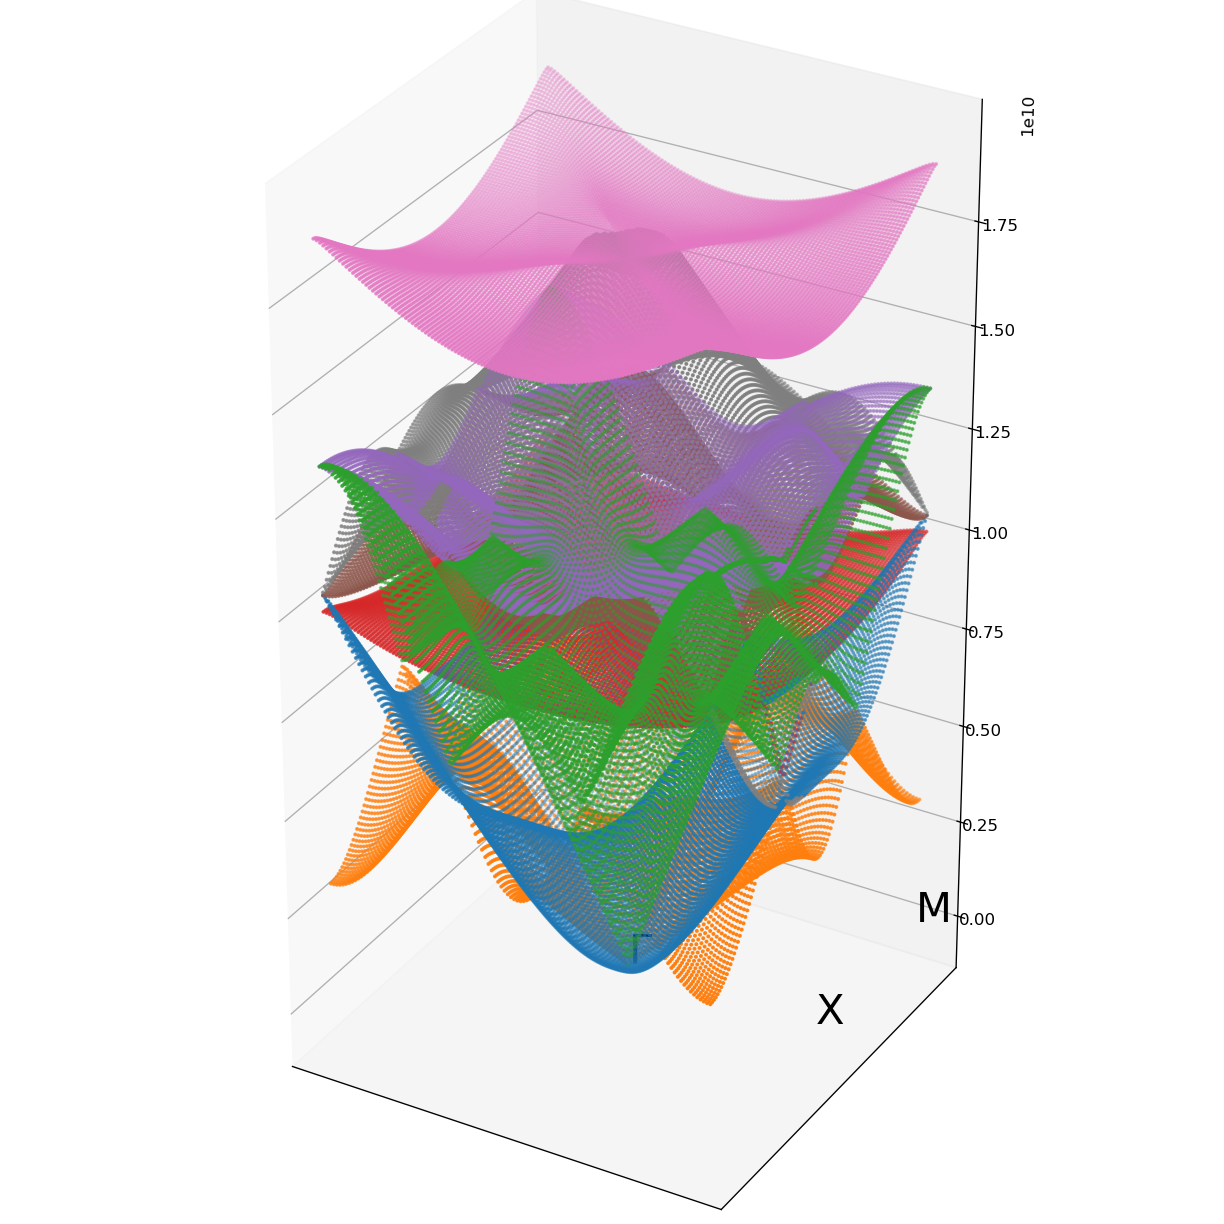

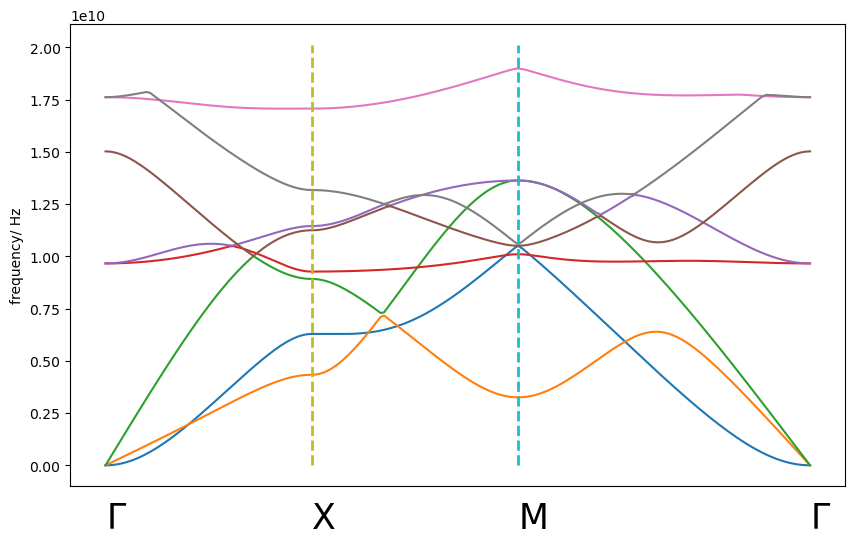

In [11]:
dataReorder=copy.deepcopy(freq_data)
stage=0
num_failed=[num_bands_to_show]
failed_bands_indexes=[range(num_bands_to_show)]
creterion=1e99
def closest(list, target):
    a=[]
    for i in list:
        a.append(abs(target-i))
    return a.index(min(a))
def closest2(list, target):
    a=[]
    for i in list:
        a.append(abs(target-i))
    del a[a.index(min(a))]
    return a.index(min(a))
def predict(i, x, y, data_to_sort, data_obtained, search_list, target):
    position=closest([data_to_sort[i][x][y] for i in search_list], target)
    data_obtained[i][x][y]=data_to_sort[search_list[position]][x][y]
    data_to_sort[search_list[position]][x][y]=1e16
def predict2(i, x, y, data_to_sort, data_obtained, search_list, target_list):
    predict_list=[]
    for n in target_list:
        predict_list.append(closest([data_to_sort[i][x][y] for i in search_list], n))
    position=max(predict_list,key=predict_list.count)
    data_obtained[i][x][y]=data_to_sort[search_list[position]][x][y]
    data_to_sort[search_list[position]][x][y]=1e16
def checkBands(stage,dataReorder,num_failed,failed_bands_indexes):
    gradw=[[] for i in range(num_failed[stage])]
    grad2w=[[] for i in range(num_failed[stage])]
    grad2w_flatten=[[] for i in range(num_failed[stage])]
    failed_bands_indexes.append([])
    for i in range(num_failed[stage]):
        gradw[i]=np.empty((Size_x-1,Size_y-1))
        I=failed_bands_indexes[stage][i]
        for x in range(Size_x-1):
            for y in range(Size_y-1):
                gradw[i][x][y]=(dataReorder[I][x+1][y]-dataReorder[I][x][y])+(dataReorder[I][x][y+1]-dataReorder[I][x][y])
        grad2w[i]=copy.deepcopy(np.delete(gradw[i],0,-1))
        for x in range(Size_x-2):
            for y in range(Size_y-2):
                grad2w[i][x][y]=(gradw[i][x+1][y]-gradw[i][x][y])+(gradw[i][x][y+1]-gradw[i][x][y])
        grad2w_flatten[i]=np.hstack(grad2w[i])
        if max(grad2w_flatten[i])>creterion:
            failed_bands_indexes[stage+1].append(failed_bands_indexes[stage][i])
    num_failed.append(len(failed_bands_indexes[stage+1]))
    print('Band sorting stage %d complete. Sorted: %d, failed: %d, increase: %d'%(stage+1,num_bands_to_show-num_failed[stage+1],num_failed[stage+1],num_failed[stage]-num_failed[stage+1]))

#Band sorting strategy 1
data_temp=copy.deepcopy(dataReorder)
for i in failed_bands_indexes[stage]:
    search_list=range(min(num_bands_to_show,i+15))
    mid=int(Size_y/2)
    startWith=3
    for y in range(mid+startWith,Size_y):
        predict(i, mid+startWith, y, data_temp, dataReorder, search_list, 2*dataReorder[i][mid+startWith][y-1]-dataReorder[i][mid+startWith][y-2])
    for y in range(mid-startWith,-1,-1):
        predict(i, mid+startWith, y, data_temp, dataReorder, search_list, 2*dataReorder[i][mid+startWith][y+1]-dataReorder[i][mid+startWith][y+2])
    for y in range(mid+startWith,Size_y):
        predict(i, mid-startWith, y, data_temp, dataReorder, search_list, 2*dataReorder[i][mid-startWith][y-1]-dataReorder[i][mid-startWith][y-2])
    for y in range(mid-startWith,-1,-1):
        predict(i, mid-startWith, y, data_temp, dataReorder, search_list, 2*dataReorder[i][mid-startWith][y+1]-dataReorder[i][mid-startWith][y+2])
    for x in range(mid+startWith+1,Size_x):
        predict(i, x, mid+startWith, data_temp, dataReorder, search_list, 2*dataReorder[i][x-1][mid+startWith]-dataReorder[i][x-2][mid+startWith])
    for x in range(mid-startWith-1,-1,-1):
        predict(i, x, mid+startWith, data_temp, dataReorder, search_list, 2*dataReorder[i][x+1][mid+startWith]-dataReorder[i][x+2][mid+startWith])
    for x in range(mid+startWith+1,Size_x):
        predict(i, x, mid-startWith, data_temp, dataReorder, search_list, 2*dataReorder[i][x-1][mid-startWith]-dataReorder[i][x-2][mid-startWith])
    for x in range(mid-startWith-1,-1,-1):
        predict(i, x, mid-startWith, data_temp, dataReorder, search_list, 2*dataReorder[i][x+1][mid-startWith]-dataReorder[i][x+2][mid-startWith])
    for x in range(mid+startWith-1,mid-1,-1):
        for y in range(mid+startWith,Size_y):
            predict_xy=dataReorder[i][x+1][y]+dataReorder[i][x][y-1]-dataReorder[i][x+1][y-1]
            predict(i, x, y, data_temp, dataReorder, search_list, predict_xy)
        for y in range(mid-startWith,-1,-1):
            predict_xy=dataReorder[i][x+1][y]+dataReorder[i][x][y+1]-dataReorder[i][x+1][y+1]
            predict(i, x, y, data_temp, dataReorder, search_list, predict_xy)
    for x in range(mid-startWith+1,mid):
        for y in range(mid+startWith,Size_y):
            predict_xy=dataReorder[i][x-1][y]+dataReorder[i][x][y-1]-dataReorder[i][x-1][y-1]
            predict(i, x, y, data_temp, dataReorder, search_list, predict_xy)
        for y in range(mid-startWith,-1,-1):
            predict_xy=dataReorder[i][x-1][y]+dataReorder[i][x][y+1]-dataReorder[i][x-1][y+1]
            predict(i, x, y, data_temp, dataReorder, search_list, predict_xy)
    for y in range(mid+startWith-1,mid-1,-1):
        for x in range(mid+startWith,Size_x):
            predict_xy=dataReorder[i][x][y+1]+dataReorder[i][x-1][y]-dataReorder[i][x-1][y+1]
            predict(i, x, y, data_temp, dataReorder, search_list, predict_xy)
        for x in range(mid-startWith,-1,-1):
            predict_xy=dataReorder[i][x+1][y]+dataReorder[i][x][y+1]-dataReorder[i][x+1][y+1]
            predict(i, x, y, data_temp, dataReorder, search_list, predict_xy)
    for y in range(mid-startWith+1,mid):
        for x in range(mid+startWith,Size_x):
            predict_xy=dataReorder[i][x][y-1]+dataReorder[i][x-1][y]-dataReorder[i][x-1][y-1]
            predict(i, x, y, data_temp, dataReorder, search_list, predict_xy)
        for x in range(mid-startWith,-1,-1):
            predict_xy=dataReorder[i][x+1][y]+dataReorder[i][x][y-1]-dataReorder[i][x+1][y-1]
            predict(i, x, y, data_temp, dataReorder, search_list, predict_xy)
    for y in range(mid+startWith+1,Size_y):
        predict(i, -startWith, y, data_temp, dataReorder, search_list, 2*dataReorder[i][-startWith][y-1]-dataReorder[i][-startWith][y-2])
    for y in range(mid-startWith-1,-1,-1):
        predict(i, -startWith, y, data_temp, dataReorder, search_list, 2*dataReorder[i][-startWith][y+1]-dataReorder[i][-startWith][y+2])
    for y in range(mid+startWith+1,Size_y):
        predict(i, startWith, y, data_temp, dataReorder, search_list, 2*dataReorder[i][startWith][y-1]-dataReorder[i][startWith][y-2])
    for y in range(mid-startWith-1,-1,-1):
        predict(i, startWith, y, data_temp, dataReorder, search_list, 2*dataReorder[i][startWith][y+1]-dataReorder[i][startWith][y+2])
    for x in range(mid+startWith+1,Size_x-startWith):
        predict(i, x, -startWith, data_temp, dataReorder, search_list, 2*dataReorder[i][x-1][-startWith]-dataReorder[i][x-2][-startWith])
    for x in range(mid-startWith-1,startWith,-1):
        predict(i, x, -startWith, data_temp, dataReorder, search_list, 2*dataReorder[i][x+1][-startWith]-dataReorder[i][x+2][-startWith])
    for x in range(mid+startWith+1,Size_x-startWith):
        predict(i, x, startWith, data_temp, dataReorder, search_list, 2*dataReorder[i][x-1][startWith]-dataReorder[i][x-2][startWith])
    for x in range(mid-startWith-1,startWith,-1):
        predict(i, x, startWith, data_temp, dataReorder, search_list, 2*dataReorder[i][x+1][startWith]-dataReorder[i][x+2][startWith])
    for x in range(Size_x-startWith+1,Size_x):
        for y in range(mid+startWith+1,Size_y):
            predict_xy=dataReorder[i][x-1][y]+dataReorder[i][x][y-1]-dataReorder[i][x-1][y-1]
            predict_y=2*dataReorder[i][x][y-1]-dataReorder[i][x][y-2]
            predict(i, x, y, data_temp, dataReorder, search_list, (3*predict_xy+predict_y)/4)
        for y in range(mid-startWith-1,-1,-1):
            predict_xy=dataReorder[i][x-1][y]+dataReorder[i][x][y+1]-dataReorder[i][x-1][y+1]
            redict_y=2*dataReorder[i][x][y+1]-dataReorder[i][x][y+2]
            predict(i, x, y, data_temp, dataReorder, search_list, (3*predict_xy+predict_y)/4)
    for x in range(startWith-1,-1,-1):
        for y in range(mid+startWith+1,Size_y):
            predict_xy=dataReorder[i][x+1][y]+dataReorder[i][x][y-1]-dataReorder[i][x+1][y-1]
            predict(i, x, y, data_temp, dataReorder, search_list, predict_xy)
        for y in range(mid-startWith-1,-1,-1):
            predict_xy=dataReorder[i][x+1][y]+dataReorder[i][x][y+1]-dataReorder[i][x+1][y+1]
            predict(i, x, y, data_temp, dataReorder, search_list, predict_xy)
    for y in range(Size_y-startWith+1,Size_y):
        for x in range(mid+startWith+1,Size_x-startWith):
            predict_xy=dataReorder[i][x-1][y]+dataReorder[i][x][y-1]-dataReorder[i][x-1][y-1]
            predict(i, x, y, data_temp, dataReorder, search_list, predict_xy)
        for x in range(mid-startWith-1,startWith,-1):
            predict_xy=dataReorder[i][x+1][y]+dataReorder[i][x][y-1]-dataReorder[i][x+1][y-1]
            predict(i, x, y, data_temp, dataReorder, search_list, predict_xy)
    for y in range(startWith-1,-1,-1):
        for x in range(mid+startWith+1,Size_x-startWith):
            predict_xy=dataReorder[i][x-1][y]+dataReorder[i][x][y+1]-dataReorder[i][x-1][y+1]
            predict(i, x, y, data_temp, dataReorder, search_list, predict_xy)
        for x in range(mid-startWith-1,startWith,-1):
            predict_xy=dataReorder[i][x+1][y]+dataReorder[i][x][y+1]-dataReorder[i][x+1][y+1]
            predict(i, x, y, data_temp, dataReorder, search_list, predict_xy)
    for x in range(mid+startWith+1,Size_x-startWith):
        for y in range(Size_y-startWith-1,x-1,-1):
            predict_x=2*dataReorder[i][x][y+1]-dataReorder[i][x][y+2]
            predict_y=2*dataReorder[i][x-1][y]-dataReorder[i][x-2][y]
            predict_xy=dataReorder[i][x][y+1]+dataReorder[i][x-1][y]-dataReorder[i][x-1][y+1]
            predict_xy2=2*dataReorder[i][x-1][y-1]-dataReorder[i][x-2][y-2]
            predict2(i, x, y, data_temp, dataReorder, search_list, [predict_x,predict_y,predict_xy,predict_xy2])
    for y in range(mid+startWith+1,Size_y-startWith-1):
        for x in range(Size_x-startWith-1,y,-1):
            predict_x=2*dataReorder[i][x][y-1]-dataReorder[i][x][y-2]
            predict_y=2*dataReorder[i][x+1][y]-dataReorder[i][x+2][y]
            predict_xy=dataReorder[i][x][y-1]+dataReorder[i][x+1][y]-dataReorder[i][x+1][y-1]
            predict_xy2=2*dataReorder[i][x+1][y-1]-dataReorder[i][x+2][y-2]
            predict2(i, x, y, data_temp, dataReorder, search_list, [predict_x,predict_y,predict_xy,predict_xy2])
    for x in range(mid+startWith+1,Size_x-startWith):
        for y in range(startWith+1,Size_x-x):
            predict_x=2*dataReorder[i][x][y-1]-dataReorder[i][x][y-2]
            predict_y=2*dataReorder[i][x-1][y]-dataReorder[i][x-2][y]
            predict_xy=dataReorder[i][x][y-1]+dataReorder[i][x-1][y]-dataReorder[i][x-1][y-1]
            predict_xy2=2*dataReorder[i][x-1][y-1]-dataReorder[i][x-2][y-2]
            predict2(i, x, y, data_temp, dataReorder, search_list, [predict_x,predict_y,predict_xy,predict_xy2])
    for y in range(mid-startWith-1,startWith,-1):
        for x in range(Size_x-startWith-1,Size_y-y-1,-1):
            predict_x=2*dataReorder[i][x][y+1]-dataReorder[i][x][y+2]
            predict_y=2*dataReorder[i][x+1][y]-dataReorder[i][x+2][y]
            predict_xy=dataReorder[i][x][y+1]+dataReorder[i][x+1][y]-dataReorder[i][x+1][y+1]
            predict_xy2=2*dataReorder[i][x+1][y+1]-dataReorder[i][x+2][y+2]
            predict2(i, x, y, data_temp, dataReorder, search_list, [predict_x,predict_y,predict_xy,predict_xy2])
    for x in range(startWith+1,mid-startWith-1):
        for y in range(mid+startWith+1,Size_y-x+1):
            predict_x=2*dataReorder[i][x][y-1]-dataReorder[i][x][y-2]
            predict_y=2*dataReorder[i][x-1][y]-dataReorder[i][x-2][y]
            predict_xy=dataReorder[i][x][y-1]+dataReorder[i][x-1][y]-dataReorder[i][x-1][y-1]
            predict_xy2=2*dataReorder[i][x-1][y-1]-dataReorder[i][x-2][y-2]
            predict2(i, x, y, data_temp, dataReorder, search_list, [predict_x,predict_y,predict_xy,predict_xy2])
    for y in range(Size_y-startWith-1,mid+startWith+1,-1):
        for x in range(mid-startWith-1,Size_x-y,-1):
            predict_x=2*dataReorder[i][x][y+1]-dataReorder[i][x][y+2]
            predict_y=2*dataReorder[i][x+1][y]-dataReorder[i][x+2][y]
            predict_xy=dataReorder[i][x][y+1]+dataReorder[i][x+1][y]-dataReorder[i][x+1][y+1]
            predict_xy2=2*dataReorder[i][x+1][y+1]-dataReorder[i][x+2][y+2]
            predict2(i, x, y, data_temp, dataReorder, search_list, [predict_x,predict_y,predict_xy,predict_xy2])
    for x in range(startWith+1,mid-startWith-1):
        for y in range(mid-startWith-1,x-1,-1):
            predict_x=2*dataReorder[i][x][y+1]-dataReorder[i][x][y+2]
            predict_y=2*dataReorder[i][x-1][y]-dataReorder[i][x-2][y]
            predict_xy=dataReorder[i][x][y+1]+dataReorder[i][x-1][y]-dataReorder[i][x-1][y+1]
            predict_xy2=2*dataReorder[i][x-1][y+1]-dataReorder[i][x-2][y+2]
            predict2(i, x, y, data_temp, dataReorder, search_list, [predict_x,predict_y,predict_xy,predict_xy2])
    for y in range(startWith+1,mid-startWith-1):
        for x in range(mid-startWith-1,y,-1):
            predict_x=2*dataReorder[i][x][y-1]-dataReorder[i][x][y-2]
            predict_y=2*dataReorder[i][x+1][y]-dataReorder[i][x+2][y]
            predict_xy=dataReorder[i][x][y-1]+dataReorder[i][x+1][y]-dataReorder[i][x+1][y-1]
            predict_xy2=2*dataReorder[i][x+1][y-1]-dataReorder[i][x+2][y-2]
            predict2(i, x, y, data_temp, dataReorder, search_list, [predict_x,predict_y,predict_xy,predict_xy2])
checkBands(stage,dataReorder,num_failed,failed_bands_indexes)
stage=stage+1

print("Reordering eigenstates……")
disp_data_sorted=np.empty(disp_data.shape,dtype=complex)
for i in range(num_bands_to_show):
    for x in range(Size_x):
        for y in range(Size_y):
            m=np.where(dataReorder[:,x,y]==freq_data[i,x,y])[0]
            disp_data_sorted[m[0],x,y]=disp_data[i,x,y]


###Plot eigenfrequency in k-space###
plt.rcParams['figure.figsize'] = (10,12)
fig=plt.figure(dpi=120)
axes=fig.add_axes(Axes3D(fig))
plt.xticks([])
plt.yticks([])
plt.gca().set_box_aspect((1, 1, 2))
for i in range(num_bands_to_show):
    axes.scatter(kx, ky, np.hstack(dataReorder[i]), cmap="jet", marker="o",s=2)
axes.tick_params(axis='z',labelsize=10)
axes.text(0,0,-10,r"$\Gamma$",size=25)
axes.text(kx[-1],0,-10,"X",size=25)
axes.text(kx[-1],ky[-1],-10,"M",size=25)
axes.set_zlabel('')
plt.show()

Size=int(Size_x/2)
deltak0=1/int(Size_x/2)
data_path=[[] for i in range(num_bands_to_show)]
for i in range(num_bands_to_show):
    for k in range(mid,mid+Size):
        data_path[i].append(dataReorder[i][mid][k])
    for k in range(mid,mid+Size):
        data_path[i].append(dataReorder[i][k][-1])
    for k in range(1,Size+2):
        data_path[i].append(dataReorder[i][-k][-k])
kspace_1D=[float("%f" %(deltak0*i)) for i in range(2*Size)]+[float("%f" %(2+deltak0*np.sqrt(2)*i)) for i in range(Size)]+[2+np.sqrt(2)]
plt.rcParams['figure.figsize'] = (10,6)
for i in range(0,num_bands_to_show):
    plt.plot(kspace_1D,data_path[i])
Max=(1+1/num_bands_to_show)*max(data_path[num_bands_to_show-1])
plt.plot([kspace_1D[Size],kspace_1D[Size]], [0,Max], linestyle='--', linewidth=2.0)
plt.plot([kspace_1D[2*Size],kspace_1D[2*Size]], [0,Max], linestyle='--', linewidth=2.0)
plt.ylabel("frequency/ Hz")
plt.text(0,-3e9,r"$\Gamma$",size=25)
plt.text(kspace_1D[Size],-3e9,"X",size=25)
plt.text(kspace_1D[2*Size],-3e9,"M",size=25)
plt.text(kspace_1D[-1],-3e9,r"$\Gamma$",size=25)
plt.xticks([])
plt.show()


if 1:       #if 1, output bands,kx,ky
    np.savetxt("kx_%s.csv"%(filetitle),np.array(kx),delimiter=',', newline='\n', fmt='%f')
    np.savetxt("ky_%s.csv"%(filetitle),np.array(ky),delimiter=',', newline='\n', fmt='%f')
    np.savetxt("bands_%s.csv"%(filetitle),np.reshape(dataReorder,(num_bands_to_show,Size_x*Size_y)),delimiter=',', newline='\n', fmt='%f')

In [3]:
Size_x_quarter=int(Size_x/2)+1
Size_y_quarter=int(Size_y/2)+1
kx_quarter=kx.reshape(Size_y,Size_x)[Size_y_quarter-1:,Size_x_quarter-1:]
ky_quarter=ky.reshape(Size_y,Size_x)[Size_y_quarter-1:,Size_x_quarter-1:]
dataReorder_quarter=dataReorder[:,Size_y_quarter-1:,Size_x_quarter-1:]
kx_0125=[[] for y in range(Size_y_quarter)]
ky_0125=[[] for y in range(Size_y_quarter)]
dataReorder_0125=[[] for i in range(num_bands_to_show)]
for y in range(Size_y_quarter):
    kx_0125[y]=kx_quarter[y,y:]
    ky_0125[y]=ky_quarter[y,y:]
for i in range(num_bands_to_show):
    for y in range(Size_y_quarter):
        dataReorder_0125[i].extend(dataReorder_quarter[i,y,y:])
if 0:       #if 1, output bands,kx,ky
    np.savetxt("kx_%s_quarter.csv"%(filetitle),kx_quarter.flatten(),delimiter=',', newline='\n', fmt='%f')
    np.savetxt("ky_%s_quarter.csv"%(filetitle),ky_quarter.flatten(),delimiter=',', newline='\n', fmt='%f')
    np.savetxt("bands_%s_quarter.csv"%(filetitle),np.reshape(dataReorder_quarter,(num_bands_freq,Size_y_quarter*Size_x_quarter)),delimiter=',', newline='\n', fmt='%f')
if 1:       #if 1, output bands,kx,ky
    np.savetxt("kx_%s_0125.csv"%(filetitle),np.hstack(kx_0125),delimiter=',', newline='\n', fmt='%f')
    np.savetxt("ky_%s_0125.csv"%(filetitle),np.hstack(ky_0125),delimiter=',', newline='\n', fmt='%f')
    np.savetxt("bands_%s_0125.csv"%(filetitle),dataReorder_0125,delimiter=',', newline='\n', fmt='%f')

Plot Berry connection and curvature

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_134352\1558305122.py:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axes.scatter(kx, ky, np.hstack(dataReorder[i]), cmap="jet", marker="o",s=4)
C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_134352\1558305122.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axes.scatter(kx, ky, np.hstack(dataReorder[i]), cmap="jet", marker="o",s=2, alpha=.1)


<Figure size 800x600 with 0 Axes>

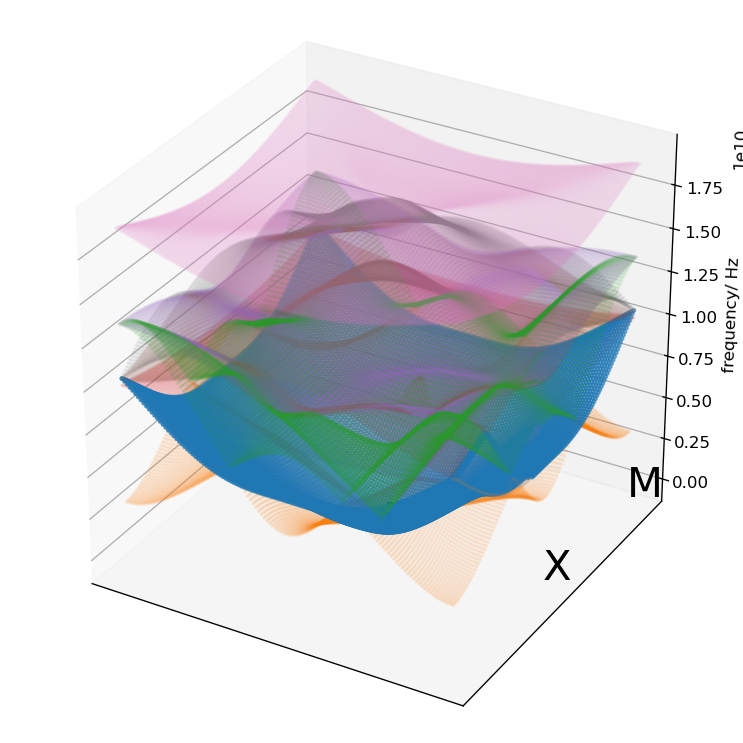

Deriving Berry connection and Berry curvature……
With band sorting:


<Figure size 1000x500 with 0 Axes>

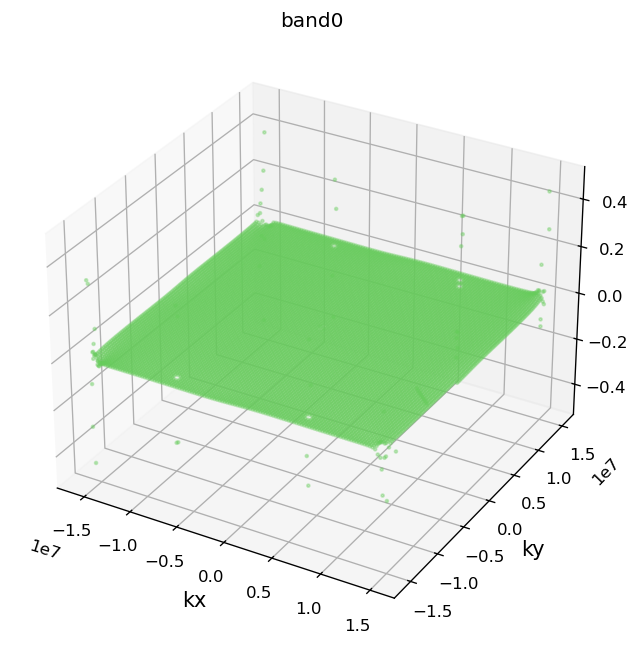

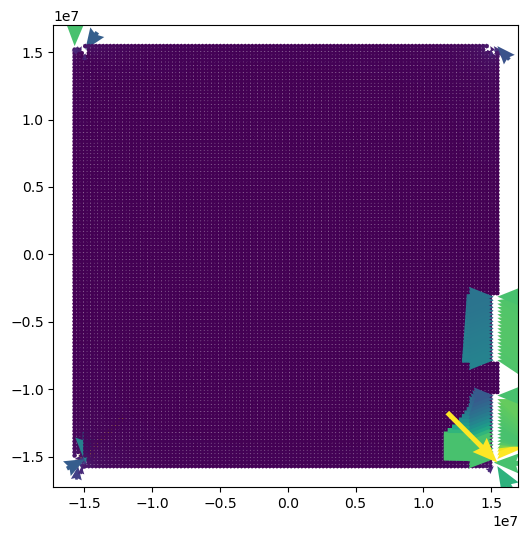

Deriving Berry connection and Berry curvature……
Without band sorting:


<Figure size 1000x500 with 0 Axes>

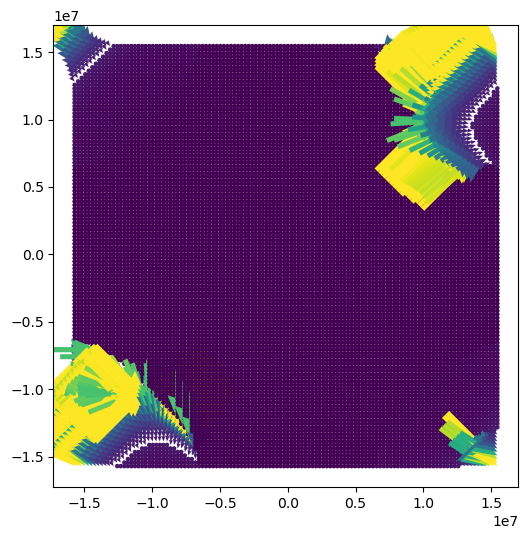

In [4]:
def plot_sorted(band_to_show,save_Berry_curvature):
    plt.rcParams['figure.figsize'] = (8,6)
    plt.figure( dpi=100)
    fig=plt.figure(dpi=120)
    axes=fig.add_axes(Axes3D(fig))
    plt.xticks([])
    plt.yticks([])
    plt.gca().set_box_aspect((1, 1, 1))
    for i in range(num_bands_to_show):
        if i!=band_to_show:
            axes.scatter(kx, ky, np.hstack(dataReorder[i]), cmap="jet", marker="o",s=2, alpha=.1)
        else:
            axes.scatter(kx, ky, np.hstack(dataReorder[i]), cmap="jet", marker="o",s=4)
    Max=max(np.hstack(dataReorder[1]))
    axes.tick_params(axis='z',labelsize=10)
    axes.text(0,0,-Max/10,r"$\Gamma$",size=25)
    axes.text(kx[-1],0,-Max/12,"X",size=25)
    axes.text(kx[-1],ky[-1],-Max/10,"M",size=25)
    axes.set_zlabel('frequency/ Hz')
    plt.show()

    ###Deriving Berry connection and Berry curvature###
    print('Deriving Berry connection and Berry curvature……')
    Ax = np.zeros((Size_x-1,Size_y-1),dtype=complex)
    Ay = np.zeros((Size_x-1,Size_y-1),dtype=complex)
    for x in range(Size_x-1):
        for y in range(Size_y-1):
            Ax[x,y]=1j*np.dot(disp_data_sorted[band_to_show,x,y].transpose().conj(), (disp_data_sorted[band_to_show,x+1,y]-disp_data_sorted[band_to_show,x,y]))
            Ay[x,y]=1j*np.dot(disp_data_sorted[band_to_show,x,y].transpose().conj(), (disp_data_sorted[band_to_show,x,y+1]-disp_data_sorted[band_to_show,x,y]))
    F = np.zeros((Size_x-2,Size_y-2),dtype=complex)
    for x in range(Size_x-2):
        for y in range(Size_y-2):
            F[x,y]=Ay[x+1,y]-Ay[x,y]-Ax[x,y+1]+Ax[x,y]
    F=np.real(F)/(deltak**2/max(kx)/max(ky))
    ky_inner2=np.array([sorted(list(set(ky)))[y]*np.ones(Size_x-1) for y in range(Size_y-1)]).T
    kx_inner2=np.tile(ky[:Size_x-1],(Size_y-1,1)).T
    ky_inner=np.array([sorted(list(set(ky)))[y]*np.ones(Size_x-2) for y in range(Size_y-2)]).T
    kx_inner=np.tile(ky[:Size_x-2],(Size_y-2,1)).T

    ###Plot the result###

    print('With band sorting:')
    plt.rcParams['figure.figsize'] = (10,5)
    plt.figure( dpi=100)
    fig=plt.figure(dpi=120)
    axes=fig.add_axes(Axes3D(fig))
    zlim=np.mean(abs(F))
    axes.set_zlim(-zlim,zlim)
    plt.gca().set_xlabel("kx",fontsize=12.5)
    plt.gca().set_ylabel("ky",fontsize=12.5)
    axes.scatter(np.hstack(kx_inner),np.hstack(ky_inner),np.hstack(F), c=np.hstack(F), marker="o",s=3)
    plt.title("band%d"%(band_to_show))
    plt.show()

    plt.rcParams['figure.figsize'] = (6,6)
    len_magnitude=np.mean(np.abs(Ax)+np.abs(Ay))
    Ax_showed=np.clip(np.real(Ax)/len_magnitude,-1,1)
    Ay_showed=np.clip(np.real(Ay)/len_magnitude,-1,1)
    color=np.hypot(Ax_showed, Ay_showed)
    plt.figure( dpi=100)
    plt.quiver(kx_inner2,ky_inner2,Ax_showed,Ay_showed, color, units='inches',pivot='tip',width=0.05, scale=2, color='red', headwidth=4, alpha=1)
    plt.show()

    if save_Berry_curvature==1:       #if 1, output Berry curvature
        np.savetxt("Berry_curvature_%s_band%d.csv"%(filetitle,band_to_show+1),np.real(F),delimiter=',', newline='\n')

def plot_unsorted(band_to_show,save_Berry_curvature):
    print('Deriving Berry connection and Berry curvature……')
    Ax = np.zeros((Size_x-1,Size_y-1),dtype=complex)
    Ay = np.zeros((Size_x-1,Size_y-1),dtype=complex)
    for x in range(Size_x-1):
        for y in range(Size_y-1):
            Ax[x,y]=1j*np.dot(disp_data[band_to_show,x,y].transpose().conj(), (disp_data[band_to_show,x+1,y]-disp_data[band_to_show,x,y]))
            Ay[x,y]=1j*np.dot(disp_data[band_to_show,x,y].transpose().conj(), (disp_data[band_to_show,x,y+1]-disp_data[band_to_show,x,y]))
    F = np.zeros((Size_x-2,Size_y-2),dtype=complex)
    for x in range(Size_x-2):
        for y in range(Size_y-2):
            F[x,y]=Ay[x+1,y]-Ay[x,y]-Ax[x,y+1]+Ax[x,y]
    F=np.real(F)/(deltak**2/max(kx)/max(ky))
    ky_inner2=np.array([sorted(list(set(ky)))[y]*np.ones(Size_x-1) for y in range(Size_y-1)]).T
    kx_inner2=np.tile(ky[:Size_x-1],(Size_y-1,1)).T
    ky_inner=np.array([sorted(list(set(ky)))[y]*np.ones(Size_x-2) for y in range(Size_y-2)]).T
    kx_inner=np.tile(ky[:Size_x-2],(Size_y-2,1)).T

    print('Without band sorting:')
    plt.rcParams['figure.figsize'] = (10,5)
    plt.figure( dpi=100)
    fig=plt.figure(dpi=120)
    axes=fig.add_axes(Axes3D(fig))
    zlim=np.mean(abs(F))
    axes.set_zlim(-zlim,zlim)
    plt.gca().set_xlabel("kx",fontsize=12.5)
    plt.gca().set_ylabel("ky",fontsize=12.5)
    axes.scatter(np.hstack(kx_inner),np.hstack(ky_inner),np.hstack(F), c=np.hstack(F), marker="o",s=3)
    plt.title("band%d,unsorted"%(band_to_show))
    plt.show()

    plt.rcParams['figure.figsize'] = (6,6)
    len_magnitude=np.mean(np.abs(Ax)+np.abs(Ay))
    Ax_showed=np.clip(np.real(Ax)/len_magnitude,-1,1)
    Ay_showed=np.clip(np.real(Ay)/len_magnitude,-1,1)
    color=np.hypot(Ax_showed, Ay_showed)
    plt.figure( dpi=100)
    plt.quiver(kx_inner2,ky_inner2,Ax_showed,Ay_showed, color, units='inches',pivot='tip',width=0.05, scale=2, color='red', headwidth=4, alpha=1)
    plt.show()

    if save_Berry_curvature==1:       #if 1, output Berry curvature
        np.savetxt("Berry_curvature_%s_band%d_unsorted.csv"%(filetitle,band_to_show+1),np.real(F),delimiter=',', newline='\n')

band_to_show=0
plot_sorted(band_to_show,save_Berry_curvature=1)
plot_unsorted(band_to_show,save_Berry_curvature=1)

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_134352\1558305122.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axes.scatter(kx, ky, np.hstack(dataReorder[i]), cmap="jet", marker="o",s=2, alpha=.1)
C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_134352\1558305122.py:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axes.scatter(kx, ky, np.hstack(dataReorder[i]), cmap="jet", marker="o",s=4)


<Figure size 800x600 with 0 Axes>

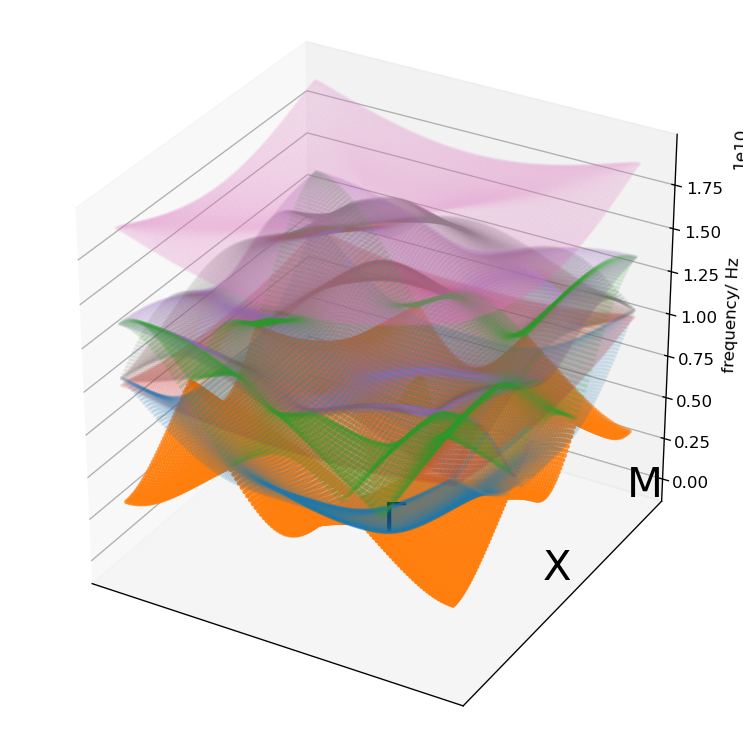

Deriving Berry connection and Berry curvature……
With band sorting:


<Figure size 1000x500 with 0 Axes>

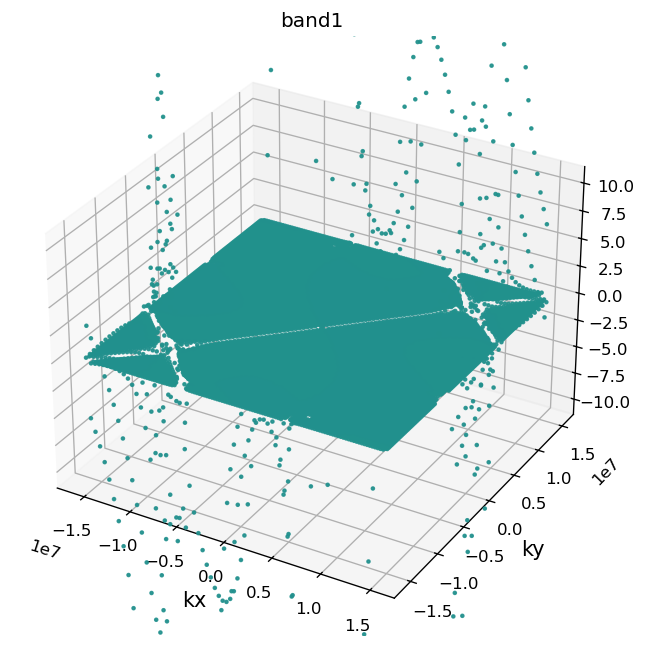

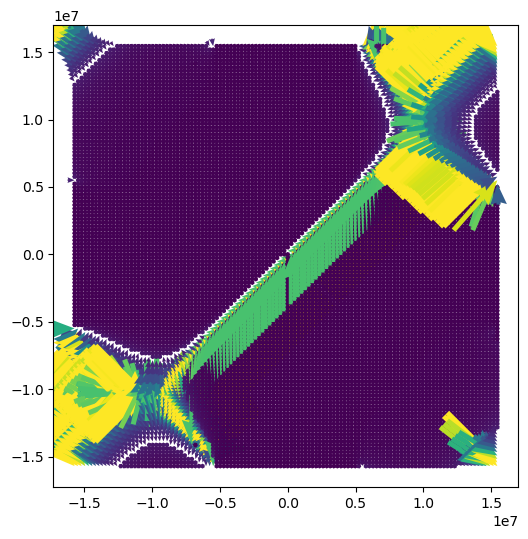

Deriving Berry connection and Berry curvature……
Without band sorting:


<Figure size 1000x500 with 0 Axes>

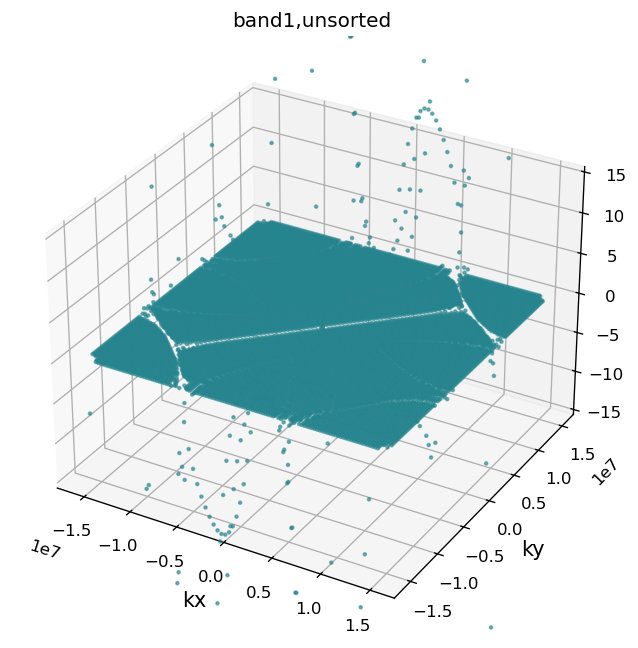

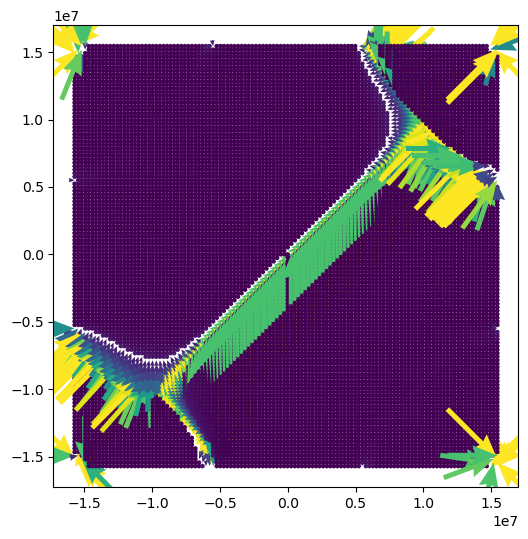

In [5]:
band_to_show=1
plot_sorted(band_to_show,save_Berry_curvature=1)
plot_unsorted(band_to_show,save_Berry_curvature=1)

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_134352\1558305122.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axes.scatter(kx, ky, np.hstack(dataReorder[i]), cmap="jet", marker="o",s=2, alpha=.1)
C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_134352\1558305122.py:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axes.scatter(kx, ky, np.hstack(dataReorder[i]), cmap="jet", marker="o",s=4)


<Figure size 800x600 with 0 Axes>

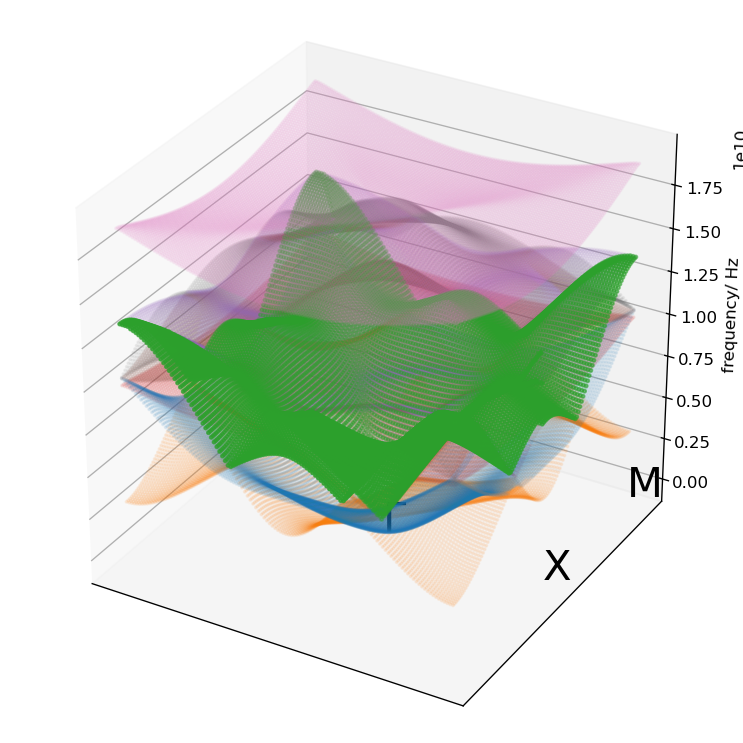

Deriving Berry connection and Berry curvature……
With band sorting:


<Figure size 1000x500 with 0 Axes>

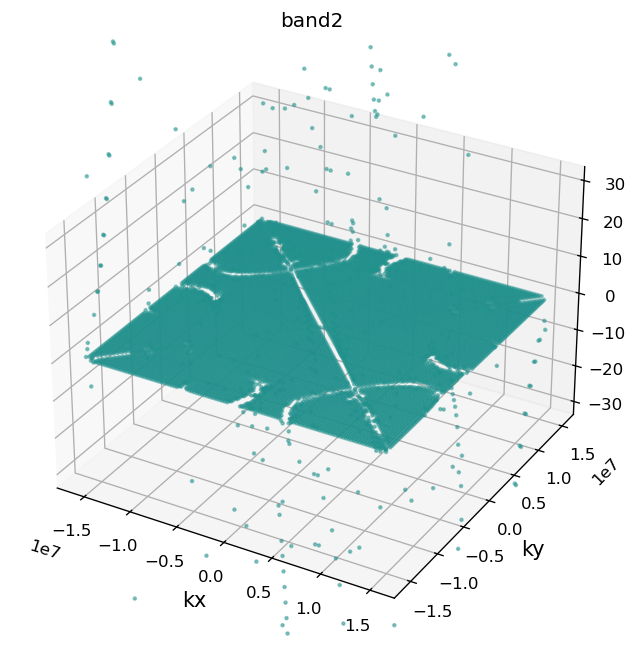

Deriving Berry connection and Berry curvature……
Without band sorting:


<Figure size 1000x500 with 0 Axes>

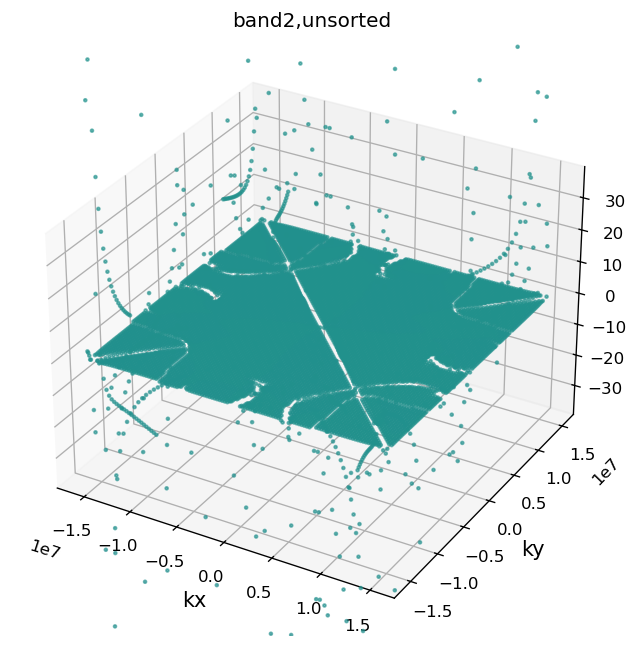

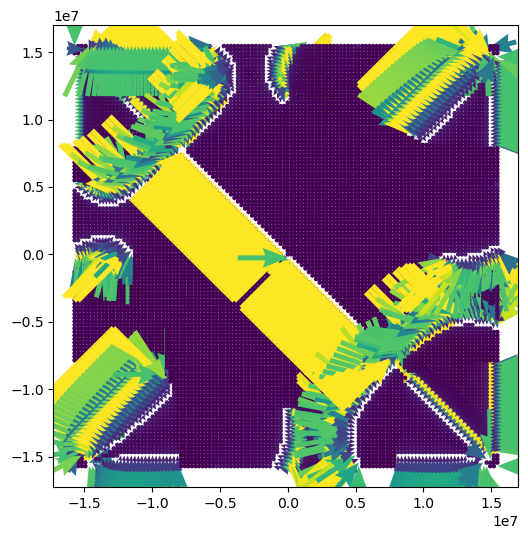

In [6]:
band_to_show=2
plot_sorted(band_to_show,save_Berry_curvature=1)
plot_unsorted(band_to_show,save_Berry_curvature=1)